In [1]:
import torch
from models.backbone import Backbone
from models.recognizer import CRNN

device = "cuda" if torch.cuda.is_available() else "cpu"

backbone = Backbone().to(device)
recognizer = CRNN().to(device)

dummy = torch.randn(1, 3, 224, 224).to(device)
feat = backbone(dummy)
log_probs = recognizer(feat)

print("Feature map:", feat.shape)
print("Log probs:", log_probs.shape)


c:\Users\abhin\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\abhin\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Feature map: torch.Size([1, 512, 7, 7])
Log probs: torch.Size([1, 7, 38])


In [2]:
import torch
from utils.reliability import detection_reliability, recognition_reliability, combine_reliability

# fake detection confidence
det_conf = torch.tensor([0.2, 0.5, 0.8])

# fake recognition output
log_probs = torch.randn(3, 10, 38).log_softmax(dim=-1)

det_w = detection_reliability(det_conf)
rec_w = recognition_reliability(log_probs)
final_w = combine_reliability(det_w, rec_w)

print("Detection weight:", det_w)
print("Recognition weight:", rec_w)
print("Final weight:", final_w)


Detection weight: tensor([0.0474, 0.5000, 0.9526])
Recognition weight: tensor([0.0419, 0.0421, 0.0441])
Final weight: tensor([0.0020, 0.0210, 0.0420])


In [3]:
import torch
from losses.weighted_loss import WeightedCTCLoss

criterion = WeightedCTCLoss()

# fake recognizer output
T, B, V = 7, 3, 38
log_probs = torch.randn(T, B, V).log_softmax(dim=-1)

# fake targets
targets = torch.randint(1, V, (12,))
target_lengths = torch.tensor([4, 4, 4])
input_lengths = torch.tensor([T, T, T])

# fake weights
weights = torch.tensor([0.1, 0.5, 1.0])

loss = criterion(
    log_probs,
    targets,
    input_lengths,
    target_lengths,
    weights
)

print("Weighted CTC loss:", loss.item())


Weighted CTC loss: 11.777215003967285


In [4]:
import torch
from models.backbone import Backbone
from models.recognizer import CRNN
from models.teacher_student import TeacherStudentSSL
from losses.weighted_loss import WeightedCTCLoss

device = "cuda" if torch.cuda.is_available() else "cpu"

backbone = Backbone().to(device)
recognizer = CRNN().to(device)
criterion = WeightedCTCLoss()

ssl_model = TeacherStudentSSL(
    backbone,
    recognizer,
    criterion
).to(device)

# fake batch
images = torch.randn(2, 3, 224, 224).to(device)
det_conf = torch.tensor([0.3, 0.8]).to(device)

T = 7
targets = torch.randint(1, 38, (10,)).to(device)
input_lengths = torch.tensor([T, T]).to(device)
target_lengths = torch.tensor([5, 5]).to(device)

loss, weights = ssl_model(
    images,
    det_conf,
    targets,
    input_lengths,
    target_lengths
)

print("SSL loss:", loss.item())
print("Reliability weights:", weights)


SSL loss: 0.29958102107048035
Reliability weights: tensor([0.0031, 0.0251], device='cuda:0')


In [5]:
s_param = next(ssl_model.student_recognizer.parameters())
t_param = next(ssl_model.teacher_recognizer.parameters())

print("Same object:", s_param.data_ptr() == t_param.data_ptr())


Same object: False


In [6]:
before = next(ssl_model.teacher_recognizer.parameters()).clone()

ssl_model.update_teacher()

after = next(ssl_model.teacher_recognizer.parameters())

print("Teacher param change magnitude:",
      torch.norm(after - before).item())


Teacher param change magnitude: 2.960731251278048e-07


In [7]:
loss, weights = ssl_model(
    images,
    det_conf,
    targets,
    input_lengths,
    target_lengths
)

print("Loss:", loss.item())
print("Weights:", weights)


Loss: 0.29958200454711914
Weights: tensor([0.0031, 0.0251], device='cuda:0')


c:\Users\abhin\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:1410.)
  result = _VF.lstm(


In [8]:
import torch


def perturb_images(images, noise_std=0.02):
    """
    Simple pixel-level perturbation
    (acts as proxy for localization noise)
    """
    noise = torch.randn_like(images) * noise_std
    return (images + noise).clamp(0, 1)


In [9]:
loss, weights = ssl_model(
    images,
    det_conf,
    targets,
    input_lengths,
    target_lengths
)

print("Total loss:", loss.item())
print("Weights:", weights)


Total loss: 0.2995823621749878
Weights: tensor([0.0031, 0.0251], device='cuda:0')


In [10]:
from data.ic15_subset import IC15Subset

dataset = IC15Subset(
    image_dir="D:\\semiETS stuffs\\semiets_scratch\\data\\ic15\\images",
    annotation_json="D:\\semiETS stuffs\\semiets_scratch\\data\\ic15\\ic15_subset.json",
    vocab="0123456789abcdefghijklmnopqrstuvwxyz",
    max_samples=5
)

sample = dataset[0]
print(sample["images"].shape)
print(sample["targets"])


torch.Size([3, 224, 224])
tensor([17, 15, 24, 11, 34, 19, 29, 30, 18, 15, 11, 30, 28, 15])


In [11]:
from data.ic15_subset import IC15Subset, ic15_collate_fn
print("Import successful")


ImportError: cannot import name 'ic15_collate_fn' from 'data.ic15_subset' (d:\semiETS stuffs\semiets_scratch\data\ic15_subset.py)

In [4]:
import json

with open("C:\\Users\\abhin\\OneDrive\\Documents\\GitHub\\SemiETS-Improvements\\data\\ctw\\annotations.json", "r") as f:
    data = json.load(f)

print(type(data))
print(list(data))


<class 'dict'>
['licenses', 'info', 'images', 'annotations', 'categories']


In [5]:
from ctw1500_subset import CTW1500Subset

ds = CTW1500Subset(
    image_dir="C:\\Users\\abhin\\OneDrive\\Documents\\GitHub\\SemiETS-Improvements\\data\\ctw\\images",
    annotation_json="C:\\Users\\abhin\\OneDrive\\Documents\\GitHub\\SemiETS-Improvements\\data\\ctw\\annotations.json",
    vocab="0123456789abcdefghijklmnopqrstuvwxyz",
    max_samples=10
)

print(len(ds))
print(ds[0]["image_ids"], ds[0]["gt_texts"])


[CTW1500] Loaded 0 samples


RuntimeError: CTW1500Subset: 0 samples loaded. Check JSON structure or image paths.

In [1]:
from ctw1500_subset import CTW1500Subset

ds = CTW1500Subset(
    image_dir="C:\\Users\\abhin\\OneDrive\\Documents\\GitHub\\SemiETS-Improvements\\data\\ctw\\images",
    annotation_dir="C:\\Users\\abhin\\OneDrive\\Documents\\GitHub\\SemiETS-Improvements\\data\\ctw\\ctw1500_train_labels",
    vocab="0123456789abcdefghijklmnopqrstuvwxyz",
    max_samples=10
)

print(len(ds))
print(ds[0]["image_ids"], ds[0]["gt_texts"])


[CTW1500] Loaded 10 samples
10
0001.jpg mexico, d. f.


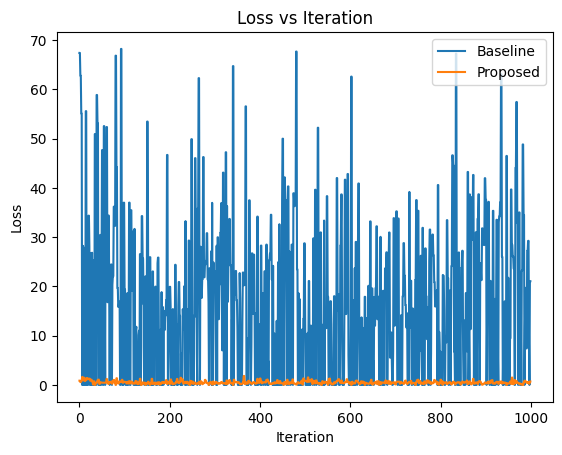

In [2]:
import json
import matplotlib.pyplot as plt

with open("experiment_logs_baseline/epoch_0.json") as f:
    baseline = json.load(f)

with open("experiment_logs/epoch_0.json") as f:
    proposed = json.load(f)

baseline_loss = [x["loss"] for x in baseline]
proposed_loss = [x["loss"] for x in proposed]

plt.figure()
plt.plot(baseline_loss, label="Baseline")
plt.plot(proposed_loss, label="Proposed")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs Iteration")
plt.show()


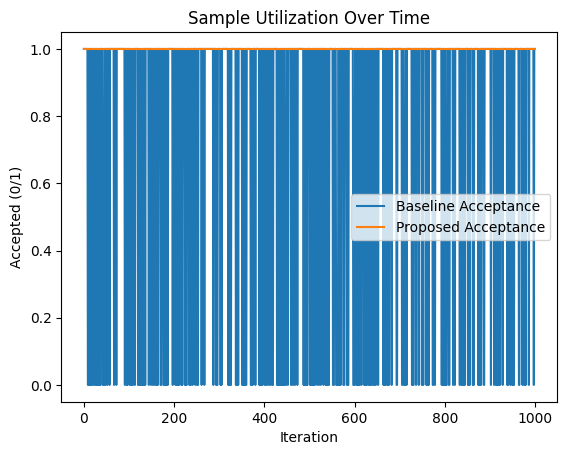

In [3]:
baseline_util = [x["baseline_accept"] for x in baseline]
proposed_util = [1 for _ in proposed]  # always accepted

plt.figure()
plt.plot(baseline_util, label="Baseline Acceptance")
plt.plot(proposed_util, label="Proposed Acceptance")
plt.xlabel("Iteration")
plt.ylabel("Accepted (0/1)")
plt.legend()
plt.title("Sample Utilization Over Time")
plt.show()


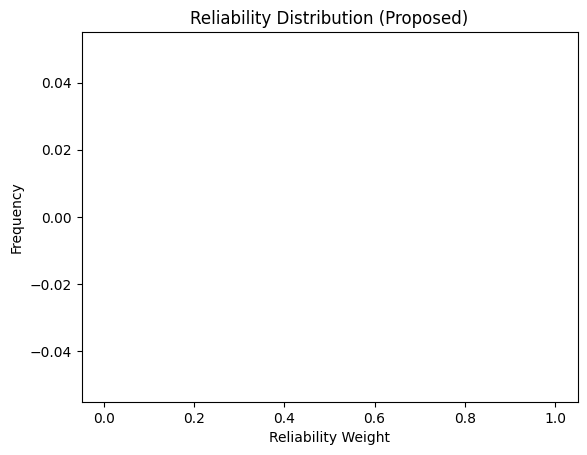

In [4]:
reliability = [x["reliability"] for x in proposed if "reliability" in x]

plt.figure()
plt.hist(reliability, bins=30)
plt.xlabel("Reliability Weight")
plt.ylabel("Frequency")
plt.title("Reliability Distribution (Proposed)")
plt.show()
